In [1]:
## plot
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection
import matplotlib.colors as colors
import matplotlib.cm as cmx


## operations
import numpy as np
from scipy.io import loadmat
from scipy import signal
from scipy.signal import butter, lfilter
from scipy import stats
from scipy.interpolate import interp1d

## time_frequency
from mne.time_frequency import tfr_array_multitaper, psd_array_multitaper

## pac
# from pactools import Comodulogram, REFERENCES
# from pactools import simulate_pac

import pandas as pd

from statsmodels.formula.api import ols, mixedlm
import statsmodels.api as sm

## Saving data dictionaries
import pickle  

In [2]:
## Load study related info
with open('../Results/study_info.pickle', 'rb') as handle:
    study_info = pickle.load(handle,encoding='latin1')
    

density        = study_info['density'] 
speed          = study_info['speed'] 
dd             = study_info['dd'] ## Number of sensory cues (density)
dur            = study_info['dur'] ## Trial duration (sec)
K_i_idx        = study_info['K_i_idx']
K_i            = study_info['K_i']
uni            = study_info['uni']
t_dur          = study_info['t_dur']
t_dd           = study_info['t_dd']
sessions       = study_info['sessions'] 
ttl_idx        = study_info['ttl_idx']
hpc_electrodes = study_info['hpc_electrodes']
fs = study_info['fs']


## Load trial markers for each session
with open('../Results/trials_markers.pickle', 'rb') as handle:
    trials_markers = pickle.load(handle,encoding='latin1')

In [3]:
log_welch = np.load('../Results/log_welch_throughout_lap.npy',encoding='latin1')

In [109]:
all_sub_dom_in_space = {}

for ii in uni.astype(int): all_sub_dom_in_space[ii] = []

for sub in range(len(log_welch)):

    data = {}

    for uu in uni.astype(int):

        data[uu] = []

        for tt in range(len(log_welch[sub])):

            if int(log_welch[sub][tt][3]) == uu:

                data[uu].append( stats.zscore(log_welch[sub][tt][4]) )
#                 data[uu].append( log_welch[sub][tt][4] )



    for kk in np.sort( list(data.keys()) ):    
        mmm = np.mean(np.array(data[kk]), axis=0)
        all_sub_dom_in_space[kk].append( mmm  )


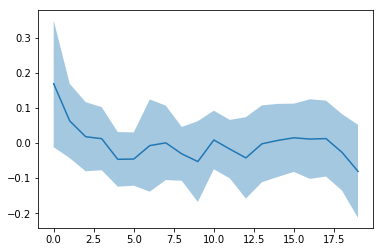

In [110]:
dom_decay = []
for cuesec in range(len(list(data.keys()))):
    
    kk = np.sort(list(data.keys()))[cuesec]
#     mm = np.mean(np.array(data[kk]), axis=0)
    mm = np.mean( np.array(all_sub_dom_in_space[kk]), axis=0)

    x = np.arange(mm.size)
    f = interp1d(x, mm)
    xnew = np.linspace(0, x[-1], 20)
    ynew = f(xnew) 

    dom_decay.append(ynew)

    
dom_decay = np.array(dom_decay)

mm = np.mean(dom_decay, axis=0)
ss = np.std(dom_decay, axis=0)

plt.fill_between( np.arange(mm.size), mm-ss, mm+ss, alpha=0.4 )
plt.plot( np.arange(mm.size), mm )

(-0.1916843425166043, 0.009944667324584025)


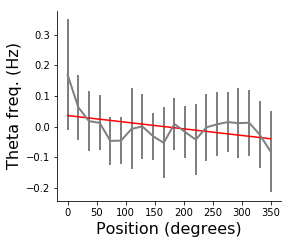

In [111]:
fig = plt.figure( figsize=(4,3.5), facecolor='white' )
ax = fig.add_subplot(111)

plt.errorbar( np.linspace(0,360,mm.size), mm, yerr=ss, color='grey', linestyle='-', linewidth=2)


xx = np.tile(np.linspace(0,360,20),9)#.reshape((9,20))
yy = dom_decay.flatten()

print( stats.pearsonr( xx,dom_decay.flatten() ) )

z = np.polyfit(xx, yy, 1)
p = np.poly1d(z)
xp = np.linspace(0, 360, 100)


plt.xticks( np.linspace(0,360,8), np.linspace(0,350,8).astype(int), rotation=0 );
plt.plot(xp, p(xp),'r')



plt.ylabel('Theta freq. (Hz)', fontsize=16)
plt.xlabel('Position (degrees)', fontsize=16)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

(-0.19168434251660427, 0.009944667324584025)


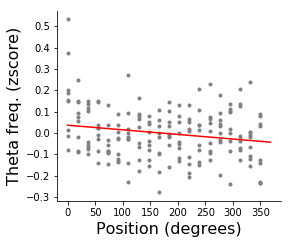

In [112]:
fig = plt.figure( figsize=(4,3.5), facecolor='white' )
ax = fig.add_subplot(111)


xx = np.tile(np.arange(20),9)#.reshape((9,20))
yy = dom_decay.flatten()


print( stats.pearsonr( xx,dom_decay.flatten() ) )

z = np.polyfit(xx, yy, 1)
p = np.poly1d(z)

xp = np.linspace(0, 20, 20)

plt.plot(xx,yy,'.', color='grey')
plt.plot(xp, p(xp),'r')

plt.xticks( np.linspace(0,19,8), np.linspace(0,350,8).astype(int), rotation=0 );

plt.ylabel('Theta freq. (zscore)', fontsize=16)
plt.xlabel('Position (degrees)', fontsize=16)


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

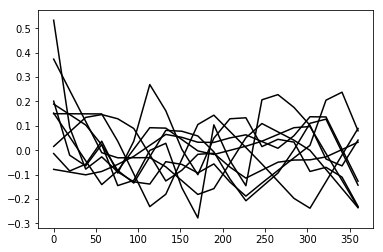

In [95]:
ss = dom_decay.shape[0]

for cuesec in range(ss):
    tmp = dom_decay[cuesec]
    plt.plot( np.linspace(0,360,mm.size), tmp, 'k')
#     plt.show()

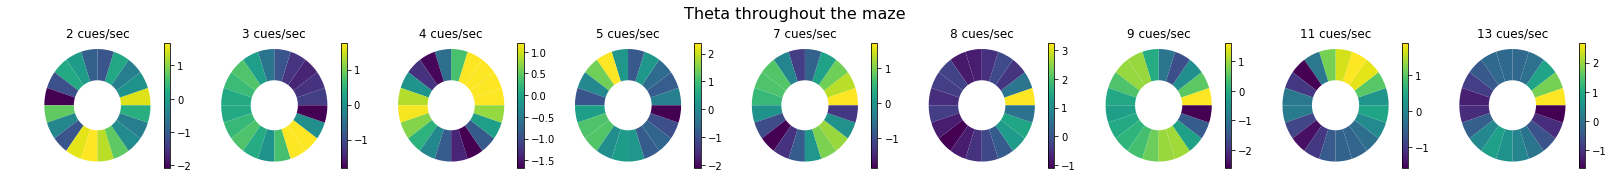

In [96]:
plt.figure( figsize=(28,2.3))
plt.suptitle("Theta throughout the maze", fontsize=16, y=1.1)

kk = np.sort(list(data.keys()))
for cuesec in range(dom_decay.shape[0]):

    ax = plt.subplot(1,len(list(data.keys())),cuesec+1)
    
    tmp = stats.zscore(dom_decay[cuesec])

    
    patches, colors = [], []
    count = 0    
    for ii in tmp:
        patches.append(  Wedge((.0, .0), .9, 360./tmp.size*count , 360./tmp.size*(count+1) , width=0.50)   )
        colors.append(ii)
        count += 1
        

    p = PatchCollection(patches)
    p.set_array(np.array(colors))

    ax.add_collection(p)

#     p.set_clim([3.9,4.6])
    plt.colorbar(p, ax=ax)

    ax.set_title(str(kk[cuesec]) + " cues/sec")
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)    
    ax.axis('off')


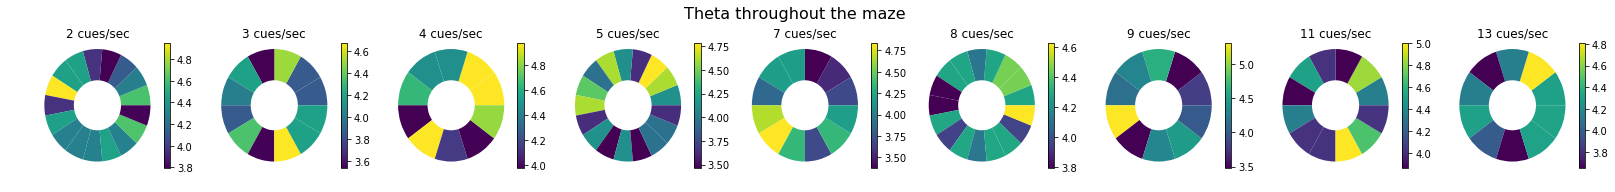

In [82]:
plt.figure( figsize=(28,2.3))
plt.suptitle("Theta throughout the maze", fontsize=16, y=1.1)

for cuesec in range(len(list(data.keys()))):

    ax = plt.subplot(1,len(list(data.keys())),cuesec+1)
    
    kk = np.sort(list(data.keys()))[cuesec]
    mm = np.mean(np.array(data[kk]), axis=0)
#     mm = np.mean( np.array(all_sub_dom_in_space[kk] ), axis=0) 



    patches, colors = [], []
    for ii in range(len(mm)):
        patches.append(  Wedge((.0, .0), .9, 360./mm.size*ii , 360./mm.size*(ii+1) , width=0.50)   )
        colors.append(mm[ii])

    p = PatchCollection(patches)
    p.set_array(np.array(colors))

    ax.add_collection(p)

#     p.set_clim([3.8,4.6])
    plt.colorbar(p, ax=ax)

    ax.set_title(str(kk) + " cues/sec")
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)    
    ax.axis('off')


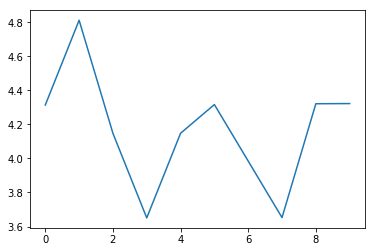

In [84]:
plt.plot(mm)

 
-4.406e-05 x + 4.237
cuesec 2
FriedmanchisquareResult(statistic=21.201656187701282, pvalue=0.1708887284984851)
------------------------------
 
-0.0002715 x + 4.275
cuesec 3
FriedmanchisquareResult(statistic=9.892778993435492, pvalue=0.5400568440421317)
------------------------------
 
-0.0007237 x + 4.477
cuesec 4
FriedmanchisquareResult(statistic=22.284738041002292, pvalue=0.008019059030295742)
------------------------------
 
-0.0005995 x + 4.293
cuesec 5
FriedmanchisquareResult(statistic=21.835409936932784, pvalue=0.1485858748714671)
------------------------------
 
-0.000454 x + 4.288
cuesec 7
FriedmanchisquareResult(statistic=22.496276828734153, pvalue=0.020798405640957248)
------------------------------
 
-0.0001811 x + 4.254
cuesec 8
FriedmanchisquareResult(statistic=17.968663594470065, pvalue=0.325735155268786)
------------------------------
 
-0.0003562 x + 4.267
cuesec 9
FriedmanchisquareResult(statistic=9.41654021244307, pvalue=0.39974528104389445)
-----------------------

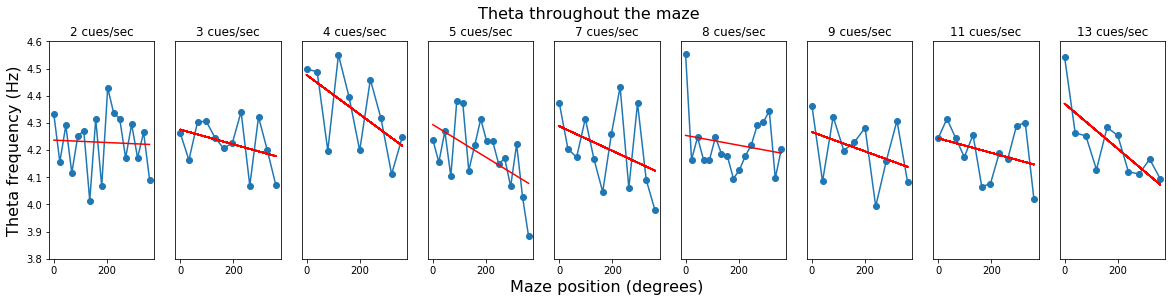

In [64]:
slopes = []
ccc = []

plt.figure( figsize=(20,4))
plt.suptitle("Theta throughout the maze", fontsize=16, y=1.)

counter = 1
for cuesec in range(len(data.keys())):
    
    kk = np.sort(list(data.keys()))[cuesec]
    mm = np.mean( np.array(all_sub_dom_in_space[kk] ), axis=0)
    
    plt.subplot(1, len(data.keys()), counter)
    plt.plot( np.linspace(0,360, mm.size),  mm, '-o')
    
    
    yy = np.array( all_sub_dom_in_space[kk] ).flatten()
    xx = np.tile(np.linspace(0,360, mm.size),8)
    z = np.polyfit(xx, yy, 1)
    p = np.poly1d(z)
    plt.plot(xx, p(xx),'r')
    
    print(p)
    slopes.append(  p(xx[-1]) - p(xx[0]) )
    ccc.append(kk)
    
    
    print( 'cuesec ' + str(kk))
    
#     print stats.friedmanchisquare(  *[ all_sub_dom_in_space[kk][ii] for ii in range(len(all_sub_dom_in_space[kk]))]  )
    print( stats.friedmanchisquare(  *[ ii for ii in np.array(all_sub_dom_in_space[kk]).T ]  ) )

    
    print( '------------------------------')
    
    
    
    r,pval = stats.pearsonr(xx,yy)

    corr_stats = "r:" +str(np.round(r,3)) +"\n p:"+  str(np.round(pval,3))
    
#     plt.text( 10, 3.85, corr_stats , fontsize=15)
    
    
    plt.title(str(kk) + " cues/sec")    
    plt.ylim(3.8,4.6)
    if counter != 1: plt.yticks([])
    if counter == 1: plt.ylabel('Theta frequency (Hz)', fontsize=16)        
    if counter == 5: plt.xlabel('Maze position (degrees)', fontsize=16)
        
    counter += 1
    
    
    
slopes = np.array(slopes)

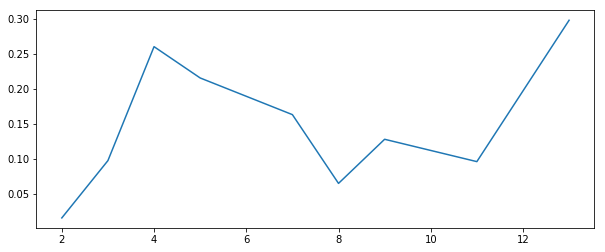

In [66]:
# jet = cm = plt.get_cmap('YlOrBr_r')
# cNorm  = colors.Normalize(vmin=0, vmax= slopes.shape[0]+1 )
# scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

plt.figure(figsize=(10,4))
# for ii in range(slopes.shape[0]):
#     colorVal = scalarMap.to_rgba(ii)
#     plt.plot(slopes[ii][0], slopes[ii][1], color=colorVal)



plt.plot(ccc, -slopes)
# plt.plot(slopes[:,0]*slopes[:,1],'-o')

# slopes

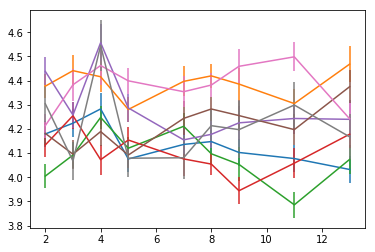

In [46]:
for sub in range(8):

    cuesec = []
    domfreqs = []
    for tt in range(len(log_welch[sub])):
        cuesec.append( int(log_welch[sub][tt][3]) )
        domfreqs.append( np.array(log_welch[sub][tt][4]) )
    domfreqs = np.array(domfreqs)


    mean_df = []
    mean_cs = []
    for df in np.unique(cuesec):
        idx = np.where(  cuesec == df )[0]
        mean_df.append(  np.concatenate(domfreqs[idx])  )
        mean_cs.append(  np.tile(np.arange(domfreqs[idx].size),domfreqs[idx][0].size) )

        
        
    
    mmm,sss = [],[]
    for ii in range(len(mean_df)):    
        mmm.append( np.mean(mean_df[ii]) )
        sss.append( stats.sem(mean_df[ii]) )    
        
    plt.errorbar( ccc, mmm, yerr=sss )

In [55]:
domfreqs[idx].shape

(10,)

<ErrorbarContainer object of 3 artists>

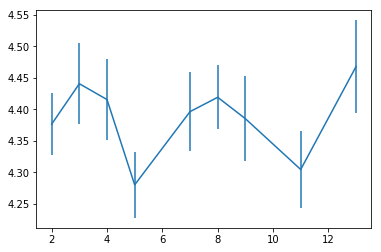

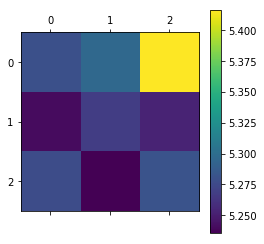

In [115]:
aa = np.zeros((8,3,3))

for sub in range(8):

    taa = np.zeros((3,3))
    
    for ii in range(len(log_welch[sub])):

        taa[ log_welch[sub][ii][1] , log_welch[sub][ii][2]  ] += np.mean(log_welch[sub][ii][4])

    taa /= 9

    aa[sub] = taa
    
aa = np.mean(aa,axis=0)
plt.matshow(aa)
plt.colorbar()
